<a id="up"></a>
# Strategic Recipes

 - [Web Scrapping](#scrapping)
 - [Load Dataset](#load)
 - [Clean Dataset](#clean)
 - [Compare Recipes](#weighting)
 - [Build Graph](#graph)
 - [Exploration](#exploration)
 - [User Interface](#user)

In [1]:
from pathlib import Path
import shutil

import pandas as pd
import numpy as np
import pickle

from bs4 import BeautifulSoup
import locale
#from html.parser import HTMLParser
# import website_func.py to use its functions
from website_func import *
from scrap import *
import os #To read the file
#reload every module each time
%load_ext autoreload
%autoreload 2

<a id="scrapping"></a>
## Web Scrapping

[Table of Contents](#up)

# Some quick analysis of the data
We received a data set of .html file containing the website content of recipes.
We wanted to sort them by website, in order to, more easily, find a pattern among them. This will enable us to do the "scraping" of the pages. First we thought about moving the files in a folder corresponding to their website, but it would be a waste of time and a big computational effort. Thus, we came up with a (probably) faster solution : we could simply write the name of the file within its corresponding website folder. By inspecting the files, we saw that the first line was always containing a comment with the name of the file and the complete website. Using readlines and split, we could easily retrieve the name of the website.

We launched this process, but an alarm appeared describing a Trojan virus in the file "1c2cb6f0df04cf5a9d0baa116c6aa7bb.html". 
We had then to quarantine or maybe remove the file, as we have quite enough data.
By doing so, we remarked the file "msg.log" that could help us into fastering the processus as its content is formed of the name of the file together with its website.

In [2]:
with open("recipePages/msg.log", 'r') as f:
    first_lines = f.readlines()[45:49]
    print(*first_lines, sep="--")

59b9d3c43ee8df52fcd04128475059f5.html	http://allrecipes.com/Recipe/bacon-and-potato-soup/detail.aspx	2012-09-09 10:55:41 URL:http://allrecipes.com/Recipe/bacon-and-potato-soup/detail.aspx [225697/225697] -> "59b9d3c43ee8df52fcd04128475059f5.tmp" [1]
--129b4dad66e6d0d59bbc6f3200f9e927.html	http://familyoven.com/recipes/search?terms=Dairy%20Free%20Alfredo%20Sauce	2012-09-09 10:55:42 URL:http://familyoven.com/recipes/search?terms=Dairy%20Free%20Alfredo%20Sauce [77640] -> "129b4dad66e6d0d59bbc6f3200f9e927.tmp" [1]
--bafcd30bc137238af0cd9954f7d0701e.html	http://www.yummly.com/recipes/chicken-brunswick-stew-lima-beans	Syntax error in Set-Cookie: fbsr_54208124338=""; Expires=Thu, 01-Jan-1970 00:00:10 GMT; Path=/, JSESSIONID=27D73083292D7FE540727DC4AD6C50D2; Path=/; HttpOnly, yv="lJSpLE5cHmHHgrNrJgtM/w=="; Version=1; Max-Age=31536000; Expires=Mon, 09-Sep-2013 17:55:42 GMT; Path=/ at position 120.
--2012-09-09 10:55:43 URL:http://www.yummly.com/recipes/chicken-brunswick-stew-lima-beans [286650]

We observed that occasionally a line containing other info that are not necessary can appear (in the example above, this is the case in the last line). Those lines are ignored during the sorting process.
Also we noticed there are no file extensions other than .html and .log (see below). Thus, we know exacty what the contents of the folder recipePages are.

In [3]:
# We can find in the folder that, excepted the html files, there is only the log
# Get all filenames (i.e. path) that are in recipePages folder 
pathlist = Path("recipePages/").glob('**/*')
i = 0
for path in pathlist:
     # because path is object not string
    path_in_str = str(path)
    if not path_in_str.endswith(".html"):
        print(path_in_str)

recipePages\msg.log


##### Sorting part of the content of the folder "recipePages" :

In [4]:
# If override True -> delete SortedFiles and re-execute the function (long)
sort_website_from_log(override=False)

Finished sorting the files


After the sorting comes the scraping part. In order to have the maximum number of data and to save some time, we'll first scrap the websites containing the higher number of files.

In [5]:
website_count=pd.Series()

for (root,dirs,files) in os.walk('SortedFiles', topdown="True"):   
        for website in dirs:
            if website == ".ipynb_checkpoints":
                continue
            filename = "SortedFiles/" + website +"/filesName.txt"
            
            f = open(filename, "r")
            number_of_link = len(f.readlines())
            line_to_add=pd.Series(number_of_link,index=[website])
            website_count = website_count.append(line_to_add)

In [6]:
#print(website_count)
print("Number of website with more than 1000 files:", len(website_count[website_count.values >1000]))
print("Number of website with less than 1000 files:", len(website_count[website_count.values <1000]))

Number of website with more than 1000 files: 19
Number of website with less than 1000 files: 85


As we can observe, 19 websites have a really high number of files, higher than a thousand. The number of files contained in the 3 first website represents 53% of the total number of files.Those are the ones that we'll focus our attention on.

In [7]:
website_count.sort_values(ascending=False,inplace=True)
website_count_used=website_count[website_count.values>1000]
print(website_count_used)
total_number_files = website_count_used.values.sum()
chosen_number_files = website_count_used[0:3].values.sum()

print("Number of files in the 3 first domains : ", chosen_number_files)
print("Percentage of chosen files among the total: ", chosen_number_files/total_number_files)

allrecipes.com             28355
food.com                   14661
foodnetwork.com            11997
yummly.com                  6590
cooks.com                   5547
epicurious.com              5060
tasteofhome.com             4820
myrecipes.com               3805
recipes.sparkpeople.com     3671
cdkitchen.com               2584
bettycrocker.com            2325
cookeatshare.com            2044
southernfood.about.com      2012
grouprecipes.com            1916
recipe.com                  1460
kraftrecipes.com            1420
eatingwell.com              1400
ifood.tv                    1295
delish.com                  1050
dtype: int64
Number of files in the 3 first domains :  55013
Percentage of chosen files among the total:  0.539279692585186


In [8]:
website_list_used=website_count_used.index.tolist()

There is a lot of words in the ingredients which aren't specific to the ingredient itself, but which are just linked to the quantity of the ingredients, or something uninteresting for us. It is difficult to extract the quantity of the ingredients, as there is a lot of different units for expressing them. Hence, we decided first to juste remove all those terms for the moment, and focus our attention only on the ingredients (not on the quantity). 

In [9]:
#Words that have to be removed from the string in the website to keep only the ingredient:
list_ingredient_to_remove = ["metrics","metric","of","teaspoon", "cup", "cups","teaspoons","ounce","ounces","pounds","pound","tablespoons","chopped","quarts","fresh",\
                            "light","plain","popped","medium","shredded","bunch","tablespoon","to","taste","pinch","freshly","ground",\
                            "canned","carcass","cubes","dried","frozen","all","purpose","grated","minced","degree","degrees","optional",\
                            "jar","quartered","marinated","strips","strip","asian","stalks","package","can","cans","box","container",\
                            "evaporated","bottle","cans","extract","squares","german","slices","crushed","uncooked","seasoning","small",\
                            "sweet","packed","sliced","heavy","condensed","finely","long","grain","sweetened","firmly","cooked","crusts","lean",\
                            "caps","mix","steaks","large","instant","crumbs","semisweet","distilled","packages","pint","miniature","preserves",\
                            "processed","chunky","prepared","seasoned","american","stock","top","sirloin","tip","peeled","spears","leaves",\
                            "belgian","bob","italian","bottles","boneless","roast","breast","meat","tenderloins","granules","chips","converted",\
                            "containers","coleslaw","florets","cube","cubed","diced","crumbled","head","thighs","halves","drumsticks","blend",\
                            "leaf","bow","tie","stuffing","dry","boiling","cover","coarse","kosher","extra","virgin","fat","free","fluid","hot",\
                            "chops","loin","shoulder","roasted","for","frying","diced","thawed","bone","hocks","shucked","leftover","corned",\
                            "weed","summer","wild","whole","very","ripe","unbaked","crust","unsalted","unsifted","unsweetened","drops","drop",\
                            "paste","thickly","swiss","skinless","flavored","quart","puff","kernels","kernel","cracked","as","tortillas","chunk",\
                            "dash","dark","hash","brown","hashbrown","hungarian","rinsed","thin","thinly","thick","stewed","cleaned","gelatin",\
                            "sifted","skim","slivered","sprigs","sage","roma","romano","pasta","reduced","sodium","refried","refrigerated",\
                            "portobello","nuggets","tater","pinto","pudding","pitted","pinches","relish","penne","deep","mild","melted",\
                            "maraschino","loaf","link","jumbo","inch","jars","jasmine","generous","gold","graham","granulated","fried","skins",\
                            "fire","firm","flaked","flank","family","size","eagle","curd","half","russet","round","vidalia","unbleached","toll",\
                            "morsels","toasted","square","soft","sharp","serrano","seedless","old","provolone","process","premium","pouch","betty",\
                            "piri","chunks","smoked","other","original","breaded","tender","tenders","flowerets","nonfat","no","calorie","tail",\
                            "greek","great","northern","southern","envelope","dill","cold","round","steak","brisket","baby","assorted"]
###################PASTA ??
list_ingredient_to_remove = sorted(list_ingredient_to_remove)
#print(list_ingredient_to_remove)

### Creation of the recipe data:
We have to be aware of certain things:
- we might get a website containing only a list of recipes
- we might find no rating -> we'll have to discard it
- we might not be able to open and read the file

For the pages containing lists of recipes, we tried to get informations about those recipes, but were unsucessful. As some links referenced in those were dead.

### Schema used for the scraping :

We will based our dataset on the 3 first websites as said before. The variables we are interested in are the following :
- The ranking, in order to have a value representing the success of the recipe.
- The number of reviews, in order to have an idea of the confidence interval for the ranking estimation.
- The time of preparation, which is a candidate which will be used to predict the ranking.
- The ingredients : The candidate which will be used to predict the ranking.

We haven't yet decided what to do exactly with the number of reviews, but as we want our ranking estimation to be significant enough, we could simply remove the recipes with a too small number of reviews.

## Pickle part of food.com

The scraping takes a lot of time, then, after each website scraped, we store the results in pickles files.

In [59]:
# Scrap all food.com files and put them in a pickle file
recipe_data_food = pd.DataFrame(columns = ['Website','Recipe','Prepare time', 'Ranking', 'Reviews', 'Ingredients'])  
list_unique_ingredients_food = []
unique_ingredients_data_food = pd.DataFrame(columns = ['Ingredient','Count'])
path_to_food_folder = Path('SortedFiles/food.com/filesName.txt')
print(path_to_food_folder)

with path_to_food_folder.open("r") as file:
    website = "food.com"
    for f in file.readlines():
        file_to_read =Path('recipePages') / f.strip()
        try:
            f = open(file_to_read,'r')
            f.close()
        except:
            #print("We can't read the page: ",file_to_read)
            continue
        recipe_data_food, list_unique_ingredients_food, unique_ingredients_data_food = scrap_food(website, file_to_read,list_ingredient_to_remove,list_unique_ingredients_food, recipe_data_food, website_list_used,unique_ingredients_data_food)
                                            
recipe_data_food


In [199]:
recipe_data_food

,Website,Recipe,Prepare time,Ranking,Reviews,Ingredients
0,food.com,Ecuadorean Quinoa and Vegetable Soup,75,4.86,31,"[quinoa, olive oil, onions, salt, potato, red ..."
1,food.com,Authentic Injera (aka Ethiopian Flat Bread),4330,3.13,17,"[teff, water, salt]"
2,food.com,Healthy Vegan Coleslaw,10,5.00,1,"[cabbage, vegan mayonnaise, apple cider vinega..."
3,food.com,Grilled Flatbread,35,4.67,14,"[active yeast, olive oil, flour, salt]"
4,food.com,Baked Margarita Pie,20,5.00,3,"[cracker, milk]"
...,...,...,...,...,...,...
12879,food.com,Healthy Italian Breadsticks or Pizza Crust,75,5.00,11,"[water, sugar, salt, olive oil, garlic powder,..."
12880,food.com,Onion Dip (Raw Vegan),15,4.67,3,"[water, sea salt, garlic clove, onion, chives]"
12881,food.com,Blink of an Eye Bell Pepper Saute,5,5.00,4,"[bell pepper, olive oil, red onion, garlic clo..."
12882,food.com,Frosted Pineapple Cookies,27,4.75,9,"[pineapple, butter, sugar, egg, vanilla, flour..."


Save data with pickle

In [207]:
recipe_data_food.to_pickle("data_pickles/recipe_data_food.pkl")
unique_ingredients_data_food.to_pickle("data_pickles/unique_ingredients_data_food.pkl")
with open('data_pickles/list_uni_ingr_food.pkl', 'wb') as f:
    pickle.dump(list_unique_ingredients_food, f)

Retrieve data with pickle

In [2]:
recipe_data = pd.read_pickle("data_pickles/recipe_data_food.pkl")
unique_ingredients_data = pd.read_pickle("data_pickles/unique_ingredients_data_food.pkl")
with open('data_pickles/list_uni_ingr_food.pkl', 'rb') as f:
    list_unique_ingredients = pickle.load(f)

In [3]:
unique_ingredients_data

,Ingredient,Count
0,quinoa,39
1,olive oil,1931
2,onions,1
3,salt,5515
4,potato,106
...,...,...
1634,chicory lettuce,1
1635,parma ham,1
1636,tagliatelle noodles,2
1637,vegan cheese,1


In [ ]:
# Scrap all foodnetwork.com files and put them in a pickle file
path_to_foodnet_folder = Path('SortedFiles/foodnetwork.com/filesName.txt')
print(path_to_foodnet_folder)

with path_to_foodnet_folder.open("r") as file:
    website = "foodnetwork.com"
    for f in file.readlines():
        file_to_read =Path('recipePages') / f.strip()
        try:
            f = open(file_to_read,'r')
            f.close()
        except:
            #print("We can't read the page: ",file_to_read)
            continue
        recipe_data,list_unique_ingredients, unique_ingredients_data= scrap_foodnetwork(website, file_to_read,list_ingredient_to_remove,list_unique_ingredients, recipe_data, website_list_used,unique_ingredients_data)


In [239]:
recipe_data.to_pickle("data_pickles/recipe_data_foodnet.pkl")
unique_ingredients_data.to_pickle("data_pickles/unique_ingredients_data_foodnet.pkl")
with open('data_pickles/list_uni_ingr_foodnet.pkl', 'wb') as f:
    pickle.dump(list_unique_ingredients_food, f)

In [245]:
recipe_data = pd.read_pickle("data_pickles/recipe_data_foodnet.pkl")
unique_ingredients_data = pd.read_pickle("data_pickles/unique_ingredients_data_foodnet.pkl")
with open('data_pickles/list_uni_ingr_foodnet.pkl', 'rb') as f:
    list_unique_ingredients = pickle.load(f)

In [ ]:
# Scrap allrecipes.com files and put them in a pickle file
path_to_allrec_folder = Path('SortedFiles/allrecipes.com/filesName.txt')
print(path_to_allrec_folder)

with path_to_allrec_folder.open("r") as file:
    website = "allrecipes.com"
    for f in file.readlines():
        file_to_read =Path('recipePages') / f.strip()
        try:
            f = open(file_to_read,'r')
            f.close()
        except:
            #print("We can't read the page: ",file_to_read)
            continue
        recipe_data, list_unique_ingredients, unique_ingredients_data = scrap_allrecipes(website, file_to_read,list_ingredient_to_remove,list_unique_ingredients, recipe_data, website_list_used,unique_ingredients_data)


In [247]:
recipe_data.to_pickle("data_pickles/recipe_data_complete.pkl")
unique_ingredients_data.to_pickle("data_pickles/unique_ingredients_data_complete.pkl")
with open('data_pickles/list_uni_ingr_complete.pkl', 'wb') as f:
    pickle.dump(list_unique_ingredients_food, f)

<a id="load"></a>
## Load Dataset

[Table of Contents](#up)

We start by reloading the dataset. But we only keep the 2000 first recipes as the computational time for building the graph is $\mathcal{O}(N^2)$ if $N$ is the number of recipes.

In [164]:
recipe_data = pd.read_pickle("data_pickles/recipe_data_complete.pkl")
unique_ingredients_data = pd.read_pickle("data_pickles/unique_ingredients_data_complete.pkl")
with open('data_pickles/list_uni_ingr_complete.pkl', 'rb') as f:
    list_unique_ingredients = pickle.load(f)

In [165]:
recipe_data = recipe_data[:2000]

Only keep the two columns Recipe and Ingredients.

In [166]:
recipe_data = recipe_data[['Recipe', 'Ingredients']].copy()

<a id="clean"></a>
## Clean Dataset

[Table of Contents](#up)

We drop duplicate ingredients in the ingredients list and sort it to drop duplicate recipes. We also remove all recipes that have no ingredients.

In [167]:
def get_sorted_list_unique_ingredients(l):
    return sorted(list(set(l)))

In [168]:
# most frequent ingredient to remove (feel free to change them)
ingr_to_remove = ['salt', 'water', 'sugar','butter', 'olive oil','sugar','flour','egg','onion','pepper','black pepper',
                  'baking soda','baking powder','vanilla','garlic clove','milk']

def remove_ingredients(ingr):
    for i in ingr_to_remove:
        if i in ingr:
            ingr.remove(i)
    return ingr

In [169]:
# Clean lists of ingredients : eliminate duplicates and sort [sugar, sugar, onions,...] -> [onions, sugar,...]
recipe_data['Ingredients'] = recipe_data['Ingredients'].apply(lambda ingr: get_sorted_list_unique_ingredients(ingr))

# Remove most frequent ingredients 
#recipe_data['Ingredients'] = recipe_data['Ingredients'].apply(lambda ingr: remove_ingredients(ingr))

# Ingredient list to single coma-separated string (comparable by "drop_duplicates" function)
recipe_data['Ingredients'] = recipe_data['Ingredients'].apply(lambda ingr_list: ','.join(ingr_list))

# Drop duplicates
recipe_data.drop_duplicates(inplace=True)

# Retain only if ingredients are not empty
recipe_data = recipe_data[recipe_data['Ingredients'] != ""]

# Back to list of ingredients
#recipe_data['Ingredients'] = recipe_data['Ingredients'].apply(lambda ingr: ingr.split(','))

<a id="weighting"></a>
## Compare Recipes

[Table of Contents](#up)

We compute the Jaccard similarity between ingredients of all pairs of recipes. We start by comparing all pairs of recipes.

In [170]:
# Give a unique index to each recipe, in increasing sequence
recipe_data['Idx'] = [i for i in range(len(recipe_data))]

In [171]:
# Order columns
recipe_data = recipe_data[['Idx', 'Recipe', 'Ingredients']]
recipe_data

,Idx,Recipe,Ingredients
0,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,..."
1,1,Authentic Injera (aka Ethiopian Flat Bread),"salt,teff,water"
2,2,Healthy Vegan Coleslaw,"apple cider vinegar,cabbage,mustard,pepper,sal..."
3,3,Grilled Flatbread,"active yeast,flour,olive oil,salt"
4,4,Baked Margarita Pie,"cracker,milk"
...,...,...,...
1994,1948,Greek Baked Fish,"capers,feta cheese,garlic clove,kalamata olive..."
1995,1949,Maryland Crab Balls,"dijon mustard,egg,flour,lemon juice,mayonnaise"
1997,1950,Meatballs With Gravy,"baking powder,beef,egg,milk,onion,pepper,salt"
1998,1951,Chicken With Parmesan Cream Sauce,"butter,chicken breasts,flour,mushroom,whipping..."


In [172]:
import pandasql
from pandasql import sqldf

In [173]:
pysqldf = lambda q: sqldf(q, globals())

In [174]:
# Join all recipes
q = """
    SELECT r1.Idx, r1.Recipe, r1.Ingredients, r2.Idx as Idx2, r2.Recipe as Recipe2, r2.Ingredients as Ingredients2
    FROM recipe_data as r1, recipe_data as r2 
    WHERE r1.Idx < r2.Idx
"""

recipes_joined = pysqldf(q)

In [175]:
recipes_joined

,Idx,Recipe,Ingredients,Idx2,Recipe2,Ingredients2
0,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",1,Authentic Injera (aka Ethiopian Flat Bread),"salt,teff,water"
1,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",2,Healthy Vegan Coleslaw,"apple cider vinegar,cabbage,mustard,pepper,sal..."
2,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",3,Grilled Flatbread,"active yeast,flour,olive oil,salt"
3,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",4,Baked Margarita Pie,"cracker,milk"
4,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",5,Lemon Tahini Dressing,"garlic clove,lemon juice,soy sauce,tahini,water"
...,...,...,...,...,...,...
1906123,1949,Maryland Crab Balls,"dijon mustard,egg,flour,lemon juice,mayonnaise",1951,Chicken With Parmesan Cream Sauce,"butter,chicken breasts,flour,mushroom,whipping..."
1906124,1949,Maryland Crab Balls,"dijon mustard,egg,flour,lemon juice,mayonnaise",1952,"Easy, Healthy Baked Chicken Breasts","black pepper,chicken breasts,chicken broth,oni..."
1906125,1950,Meatballs With Gravy,"baking powder,beef,egg,milk,onion,pepper,salt",1951,Chicken With Parmesan Cream Sauce,"butter,chicken breasts,flour,mushroom,whipping..."
1906126,1950,Meatballs With Gravy,"baking powder,beef,egg,milk,onion,pepper,salt",1952,"Easy, Healthy Baked Chicken Breasts","black pepper,chicken breasts,chicken broth,oni..."


In [176]:
def jaccard_sim(list_1, list_2):
    list_1 = list_1.split(',')
    list_2 = list_2.split(',')
    s_1 = set(list_1)
    s_2 = set(list_2)
    
    if len(s_1.union(s_2)) == 0:
        return 0
    
    return len(s_1.intersection(s_2)) / len(s_1.union(s_2))

In [177]:
# Add jaccard similarity column
recipes_joined['Similarity'] = recipes_joined.apply(lambda row: jaccard_sim(row['Ingredients'], \
                                                                           row['Ingredients2']), axis=1)

recipes_joined.head()

,Idx,Recipe,Ingredients,Idx2,Recipe2,Ingredients2,Similarity
0,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",1,Authentic Injera (aka Ethiopian Flat Bread),"salt,teff,water",0.125000
1,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",2,Healthy Vegan Coleslaw,"apple cider vinegar,cabbage,mustard,pepper,sal...",0.100000
2,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",3,Grilled Flatbread,"active yeast,flour,olive oil,salt",0.117647
3,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",4,Baked Margarita Pie,"cracker,milk",0.000000
4,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",5,Lemon Tahini Dressing,"garlic clove,lemon juice,soy sauce,tahini,water",0.111111


Another distance measure :

In [178]:
recipe_data['Ingredients'] = recipe_data['Ingredients'].apply(lambda i: i.split(','))

In [179]:
ingr_to_weight = {}

for k,v in recipe_data.explode('Ingredients')['Ingredients'].value_counts().items():
    ingr_to_weight[k] = 1/v

In [180]:
def weighted_sim(list_1, list_2):
    list_1 = list_1.split(',')
    list_2 = list_2.split(',')
    
    s_1 = set(list_1)
    s_2 = set(list_2)
    
    intersection = s_1.intersection(s_2)
    union = s_1.union(s_2)
    
    if len(s_1.union(s_2)) == 0:
        return 0
    
    intersection_sum = 0
    for i in intersection:
        intersection_sum += ingr_to_weight[i]
    
    union_sum = 0
    for i in union:
        union_sum += ingr_to_weight[i]
    
    return intersection_sum/union_sum

In [181]:
# Add another distance column
recipes_joined['Weighted Similarity'] = recipes_joined.apply(lambda row: weighted_sim(row['Ingredients'], \
                                                                       row['Ingredients2']), axis=1)

recipes_joined.head()

,Idx,Recipe,Ingredients,Idx2,Recipe2,Ingredients2,Similarity,Weighted Similarity
0,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",1,Authentic Injera (aka Ethiopian Flat Bread),"salt,teff,water",0.125000,0.001252
1,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",2,Healthy Vegan Coleslaw,"apple cider vinegar,cabbage,mustard,pepper,sal...",0.100000,0.002624
2,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",3,Grilled Flatbread,"active yeast,flour,olive oil,salt",0.117647,0.002593
3,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",4,Baked Margarita Pie,"cracker,milk",0.000000,0.000000
4,0,Ecuadorean Quinoa and Vegetable Soup,"coriander,cumin,green bell pepper,lemon juice,...",5,Lemon Tahini Dressing,"garlic clove,lemon juice,soy sauce,tahini,water",0.111111,0.004098


In [182]:
recipe_data['Ingredients'] = recipe_data['Ingredients'].apply(lambda i: ','.join(i))

<a id="graph"></a>
## Build Graph

[Table of Contents](#up)

In [183]:
import networkx as nx

recipes_G = nx.Graph()

# Add nodes
recipes_G.add_nodes_from(list(recipe_data['Idx'].keys()))

In [184]:
def get_recipe_from_idx(idx):
    return recipe_data.loc[recipe_data['Idx'] == idx]

def get_recipe_name_from_idx(idx):
    return get_recipe_from_idx(idx)['Recipe'].values[0]

def get_ingredients_from_idx(idx):
    return get_recipe_from_idx(idx)['Ingredients'].values[0]

In [185]:
#nx.set_node_attributes(recipes_G, idx_to_recipe, 'recipe')
#nx.set_node_attributes(recipes_G, idx_to_ingredients, 'ingredients')

In [186]:
# Add edges to recipe graph
edge_list = []
threshold = 0.1

for _,row in recipes_joined.iterrows():
    sim = row['Weighted Similarity']
    
    if sim > threshold:
        edge_list.append((row['Idx'], row['Idx2'], sim))
    
recipes_G.add_weighted_edges_from(edge_list)

In [187]:
recipes_G.number_of_edges(), recipes_G.number_of_nodes()

(28136, 1994)

In [188]:
# Save Graph
nx.write_gpickle(recipes_G,"graph_files/recipes_G.gpickle")

- gérer mêmes noms de recettes pour recettes avec mêmes ingrédients ou avec ingrédients différents
- faire en pandasql recipes_joined
- ajouter la liste des ingrédients comme attribut d'un noeud
- clustering du graph
- déterminer une liste d'ingrédients type de chaque cluster
    - pour ca : dictionnaire ingredient->nb_occurrences pour chaque cluster

<a id="exploration"></a>
## Exploration

[Table of Contents](#up)

In [189]:
recipes_G = nx.read_gpickle("graph_files/recipes_G.gpickle")

Here, we load the weighted adjacency matrix computed before : the nodes are the recipes

In [190]:
adj = nx.adjacency_matrix(recipes_G)

In [191]:
from networkx.algorithms.cluster import average_clustering
n_nodes = recipes_G.number_of_nodes()
n_edges = recipes_G.number_of_edges()
clust_coeff=average_clustering(recipes_G)

In [192]:
print('Graph properties :\n Nodes : {}\n Edges : {}\n Average clustering coefficient {:0.2f}\n Diameter : infinity (there is some isolated nodes)'.format(n_edges, n_nodes, clust_coeff))

Graph properties :
 Nodes : 28136
 Edges : 1994
 Average clustering coefficient 0.40
 Diameter : infinity (there is some isolated nodes)


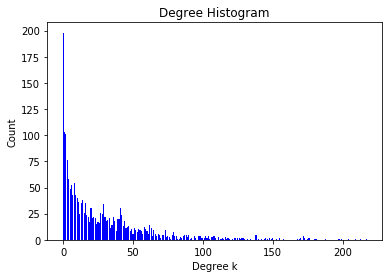

Average degree <k> : 28 


In [193]:
#Visualization code inspired from https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_degree_histogram.html
import networkx as nx
import collections
import matplotlib.pyplot as plt

degree_sequence = sorted([d for n, d in recipes_G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree k")
plt.show()
k_averaged=0
for n, d in recipes_G.degree():
    k_averaged+=d
k_averaged=k_averaged/n_nodes
print('Average degree <k> : {:0.0f} '.format(k_averaged))

From the information computed above we can see that this is a scale-free graph : it has a lot of small-degree nodes and only a few hubs

### Spectral analysis

In [194]:
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigs

#Compute normalized Laplacian (for sparse matrix)
laplacian_norm = laplacian(adj, normed=True, return_diag=False, use_out_degree=False)

#Compute eigenvectors and eigenvalues of the Laplacian (for sparse matrix)
N=laplacian_norm.shape[0]-1
lamb_norm, U_norm = eigs(laplacian_norm,k=N-1)

In [195]:
#As the output is in complex format, we have to convert it (but the imaginary part is zero)
lamb_norm=np.real(lamb_norm)
U_norm=np.real(U_norm)

#We sort the eigenvalues and their corresponding eigenvectors by ascending order
idx=np.argsort(lamb_norm)
lamb_norm=lamb_norm[idx]

#And we compute the number of connected components
n_CC = np.count_nonzero(lamb_norm <= 1e-12)

Number of connected coponents : 223


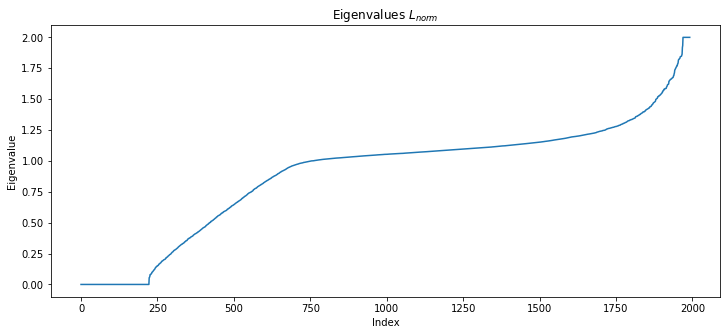

In [196]:
print("Number of connected coponents :",n_CC)
plt.figure(figsize=(12,5))
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

### Dimensionality reduction

In [197]:
#Taken from assignment 2 solution
def laplacian_eigenmaps(n_CC, U, dim):
    """ Return:
        coords (n x dim array): new coordinates for the data points."""
    # number of connected components = number of zero eigenvalues, 
    # zero eigenvalues are associated with constant vectors 
    # only take columns associated with non-zero eigenvalues
    cols_to_take = range(n_CC, n_CC + dim + 1)
    coords = U[:, cols_to_take]
    #Normalize
    coords = coords / np.linalg.norm(coords, axis=1)[:, None]
    return coords

We choose to keep the n_classes(choice) eigenvectors corresponding to the first non-trivial eigenvalues :

In [198]:
n_classes=5
U_first_non_triv_col=laplacian_eigenmaps(n_CC, U=U_norm, dim=n_classes)

### Spectral clustering

Now that we have a reduced eigenspace, we can apply spectral clustering on it :

In [199]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_classes).fit_predict(U_first_non_triv_col)

In [200]:
import itertools
list_clusters=[]

# Count occurence of ingredients within each cluster
for c in range(n_classes):
    nb_recipes=sum(y_pred == c)
    all_ingr={}
    for i, l in enumerate(y_pred==c):
        if l and i<1800:
            name = get_recipe_name_from_idx(i)
            ingredients = get_ingredients_from_idx(i).split(',')
            if len(ingredients) > 2:
                for ingr in ingredients:
                    if ingr not in all_ingr.keys():
                        all_ingr[ingr] = 1
                    else:
                        all_ingr[ingr] += 1
                    
    #Sort ingredients of cluster by occurence                    
    all_ingr_sorted={k: v for k, v in sorted(all_ingr.items(), reverse=True, key=lambda item: item[1])}
    
    #add number of recipes in dict to sort cluster by size
    all_ingr_sorted.update({'total': nb_recipes})
    list_clusters.append(all_ingr_sorted.copy()) 
    
list_clusters=sorted(list_clusters, key = lambda i: i['total'],reverse=True)

#Print most frequent ingredient within each cluster
for c in range(len(list_clusters)):
    print('Cluster {} has {} recipes'.format(c, list_clusters[c]['total']))
    del list_clusters[c]['total']
    #print only first ingredients
    N=11
    out = dict(list(list_clusters[c].items())[0: N])  
    print(out)
 

Cluster 0 has 725 recipes
{'salt': 274, 'sugar': 190, 'butter': 177, 'onion': 167, 'flour': 144, 'egg': 131, 'water': 125, 'olive oil': 93, 'garlic clove': 86, 'vanilla': 83, 'milk': 80}
Cluster 1 has 703 recipes
{'salt': 282, 'sugar': 230, 'butter': 185, 'flour': 154, 'egg': 143, 'water': 126, 'onion': 121, 'milk': 113, 'vanilla': 99, 'olive oil': 85, 'baking powder': 67}
Cluster 2 has 209 recipes
{'salt': 75, 'sugar': 71, 'butter': 53, 'flour': 46, 'water': 45, 'egg': 42, 'onion': 33, 'vanilla': 26, 'garlic clove': 24, 'olive oil': 21, 'pepper': 20}
Cluster 3 has 192 recipes
{'salt': 76, 'sugar': 51, 'butter': 43, 'egg': 32, 'flour': 27, 'onion': 27, 'water': 22, 'milk': 22, 'vanilla': 20, 'garlic clove': 17, 'baking powder': 16}
Cluster 4 has 165 recipes
{'salt': 57, 'sugar': 38, 'butter': 34, 'water': 31, 'onion': 30, 'egg': 24, 'black pepper': 24, 'flour': 23, 'milk': 18, 'vanilla': 16, 'garlic clove': 16}


In [201]:
#Save 'typical recipe' of each cluster
#This will give an extract from the most frequent ingredients starting at ingredient number 'ingr_start' and stopping at 'ingr_stop'
typical_recipe_clusters=[]
ingr_start=1
ingr_stop=20
for c in range(len(list_clusters)):
    print('Cluster {} typical recipe :'.format(c))
    typical_recipe=list(dict(list(list_clusters[c].items())[ingr_start: ingr_stop]).keys())
    print(typical_recipe)
    print('\n')
    typical_recipe_clusters.append(typical_recipe)

Cluster 0 typical recipe :
['sugar', 'butter', 'onion', 'flour', 'egg', 'water', 'olive oil', 'garlic clove', 'vanilla', 'milk', 'black pepper', 'pepper', 'garlic', 'tomatoes', 'cinnamon', 'parsley', 'potatoes', 'baking soda', 'margarine']


Cluster 1 typical recipe :
['sugar', 'butter', 'flour', 'egg', 'water', 'onion', 'milk', 'vanilla', 'olive oil', 'baking powder', 'pepper', 'garlic clove', 'black pepper', 'lemon juice', 'cinnamon', 'baking soda', 'garlic', 'parsley', 'garlic powder']


Cluster 2 typical recipe :
['sugar', 'butter', 'flour', 'water', 'egg', 'onion', 'vanilla', 'garlic clove', 'olive oil', 'pepper', 'milk', 'baking soda', 'lemon juice', 'baking powder', 'black pepper', 'parsley', 'cornstarch', 'cinnamon', 'cream cheese']


Cluster 3 typical recipe :
['sugar', 'butter', 'egg', 'flour', 'onion', 'water', 'milk', 'vanilla', 'garlic clove', 'baking powder', 'black pepper', 'cinnamon', 'pepper', 'olive oil', 'baking soda', 'parsley', 'sour cream', 'cheddar cheese', 'oreg

<a id="user"></a>
## User interface

[Table of Contents](#up)

In [254]:
def jaccard_sim_list(list_1, list_2):
    s_1 = set(list_1)
    s_2 = set(list_2)
    
    if len(s_1.union(s_2)) == 0:
        return 0
    
    return len(s_1.intersection(s_2)) / len(s_1.union(s_2))

def jaccard_sim_df_list(list_1, list_2):
    list_1 = list_1.split(',')
    s_1 = set(list_1)
    s_2 = set(list_2)
    
    if len(s_1.union(s_2)) == 0:
        return 0
    
    return len(s_1.intersection(s_2)) / len(s_1.union(s_2))

# extract the N most similar recipes
def find_best_index(N, best_cluster_df):
    sim = np.copy(best_cluster_df['Similarity'].values)
    saveList = list(sim)
    sim.sort()
    #best_recipes_index = [saveList.index(sim[-i]) for i in np.arange(1, N + 1)]
    best_score = sim[-N:]
    best_recipes_index = []
    for i in np.unique(best_score):
        idx_to_add = np.array(np.where(saveList == i))[0]
        best_recipes_index.extend(idx_to_add)

    #we keep only the N best recipes
    best_recipes_index = best_recipes_index[-N:]
    return best_recipes_index

# filter the forbidden recipes
def checkForbiddenIngred(ingredList, Not_wanted_ingredient):
    ingredList = ingredList.split(',')
    result = True
    if any([n in Not_wanted_ingredient for n in ingredList]):
        result = False
    return result

def computeFinalList(allIngredList, Not_wanted_ingredient, N):
    allowedIndex = []
    for i in range(N):
        if checkForbiddenIngred(allIngredList[i], Not_wanted_ingredient):
            allowedIndex.append(i)


    return allowedIndex


In [284]:
def find_recipes(User_ingredients, Not_wanted_ingredient):
    
#     User_ingredients = ['salt', 'butter', 'onion', 'egg', 'flour']
#     Not_wanted_ingredient = ['salt']
    # Number of ingredients chosen by the user
    num_ingred = len(User_ingredients)
    # compute the best cluster
    #Save 'typical recipe' of each cluster
    #This will give an extract from the most frequent ingredients starting at ingredient number 'ingr_start' and stopping at 'ingr_stop'
    typical_recipe_clusters=[]
    ingr_start=14
    ingr_stop=num_ingred + ingr_start
    for c in range(len(list_clusters)):
        #print('Cluster {} typical recipe :'.format(c))
        typical_recipe=list(dict(list(list_clusters[c].items())[ingr_start: ingr_stop]).keys())
        typical_recipe_clusters.append(typical_recipe)
    
    
    cluster_candidate = typical_recipe_clusters.copy()
    similarities = [jaccard_sim_list(User_ingredients, i) for i in cluster_candidate]
    best_cluster = np.argmax(similarities)
    #print(best_cluster)
    #print(cluster_candidate[best_cluster])
    
    # compute the list of recipes in this best cluster
    list_recipes = list_clusters[best_cluster]
    idx = np.array(np.where(y_pred == best_cluster))[0] # convert from tupple to array
    #print(idx)
    best_cluster_df = recipe_data[np.array([True if n in idx else False for n in recipe_data['Idx']])]
    # add similarity column
    best_cluster_df['Similarity'] = best_cluster_df.apply(lambda row: jaccard_sim_df_list(row['Ingredients'], \
                                                                           User_ingredients), axis=1)

    
    N = 10
    iterator = 0
    boolTest = False
    while not boolTest:
        # put these best recipes in a dataframe
        best_recipes_index = find_best_index(N, best_cluster_df)
        best_recipes_df = best_cluster_df[np.array([True if i in best_recipes_index else False for i in range(best_cluster_df.shape[0])])]
        #best_recipes_df.head(10)
        allIngredList = best_recipes_df['Ingredients'].values
        allowedIndex = computeFinalList(allIngredList, Not_wanted_ingredient, N)
        iterator += 1
        if len(allowedIndex) > 0 or iterator > 4:
            boolTest = True
        else:
            N = 3*N

    if(len(allowedIndex) > 0):
        final_recipes = best_recipes_df[np.array([True if i in allowedIndex else False for i in range(best_recipes_df.shape[0])])]
        return final_recipes, 1
    else:
        print('No recipes found')
        return 0, 0
    

#final_recipes.head(10)

In [285]:
test, typeOfData = find_recipes()
print(test2)

test.head()


TypeError: find_recipes() missing 2 required positional arguments: 'User_ingredients' and 'Not_wanted_ingredient'

In [ ]:
import ipywidgets as widgets
from IPython.display import clear_output

In [286]:
list_ingredients = []

for elem in list(set(recipe_data['Ingredients'])):
    ingredients_intermediaire = elem.split(",")
    for i in range(len(ingredients_intermediaire)):
        list_ingredients.append(ingredients_intermediaire[i])
        list_ingredients = sorted(list(set(list_ingredients)))    

In [287]:
User_ingredients = []

def on_button_add_clicked(b):
    with output:
        User_ingredients.append(add_ingredient.value)
        print('%s added in ingredients' %add_ingredient.value)        
        
def on_button_remove_clicked(b):
    with output:
        if remove_ingredient.value in User_ingredients:
            User_ingredients.remove(remove_ingredient.value)
            print('%s removed from ingredients' %remove_ingredient.value)


add_ingredient=widgets.Combobox(
    placeholder='Add ingredient',
    options=list_ingredients,
    description='Add:',
    ensure_option=True,
    disabled=False,
    style =  {'description_width': 'initial', 'placeholder_width':'2cm'}
)
remove_ingredient = widgets.Combobox(
    placeholder='Add ingredient',
    options=list_ingredients,
    description='Remove:',
    ensure_option=True,
    disabled=False,
    style =  {'description_width': 'initial', 'placeholder_width':'2cm'}
)
button_add = widgets.Button(description="Add ingredient")
button_remove = widgets.Button(description="Remove ingredient")

#display(add_ingredient, button_add, remove_ingredient,button_remove,button_finish,output)

button_add.on_click(on_button_add_clicked)
button_remove.on_click(on_button_remove_clicked)

In [288]:
Not_wanted_ingredient = []


def on_button_add_unwanted_clicked(b):
    with output:
        Not_wanted_ingredient.append(add_unwanted_ingredient.value)
        print('%s added in unwanted ingredients' %add_ingredient.value)        
        
def on_button_remove_unwanted_clicked(b):
    with output:
        if remove_ingredient.value in User_ingredients:
            Not_wanted_ingredient.remove(remove_unwanted_ingredient.value)
            print('%s removed from unwanted ingredients' %remove_ingredient.value)


add_unwanted_ingredient=widgets.Combobox(
    placeholder="Add ingredient",
    options=list_ingredients,
    description="Add:",
    ensure_option=True,
    disabled=False,
    style =  {'description_width': 'initial', 'placeholder_width':'2cm'}
)
remove_unwanted_ingredient = widgets.Combobox(
    placeholder='Add ingredient',
    options=list_ingredients,
    description='Remove:',
    ensure_option=True,
    disabled=False,
    style =  {'description_width': 'initial', 'placeholder_width':'2cm'}
)
button_add_unwanted = widgets.Button(description="Add ingredient")
button_remove_unwanted = widgets.Button(description="Remove ingredient")

#display(add_ingredient, button_add, remove_ingredient,button_remove,button_finish,output)

button_add_unwanted.on_click(on_button_add_unwanted_clicked)
button_remove_unwanted.on_click(on_button_remove_unwanted_clicked)

In [303]:
import warnings
def on_button_finish_clicked(b):
    with output:
        
        final_recipes, dataType = find_recipes(User_ingredients, Not_wanted_ingredient)
        if(dataType == 1):
            warnings.filterwarnings("ignore")
            display(final_recipes.head(10))
        else:
            print('No recipes found')
        #print(User_ingredients)
        #print(Not_wanted_ingredient)
def on_button_clear_clicked(b):
    with output:
        del User_ingredients[:]
        del Not_wanted_ingredient[:]
        clear_output()

button_finish = widgets.Button(description="Find my recipe")
button_clear = widgets.Button(description="clear")
output = widgets.Output(layout={'border': '1px solid black','width':'90%','align_self' : 'center'})

button_finish.on_click(on_button_finish_clicked)
button_clear.on_click(on_button_clear_clicked)

In [304]:
box_layout = widgets.Layout(width = '100%', align_items = 'stretch', align_self = 'stretch')
u1 = widgets.HBox([add_ingredient,button_add,remove_ingredient,button_remove])
u2 = widgets.HBox([add_unwanted_ingredient,button_add_unwanted,remove_unwanted_ingredient,button_remove_unwanted])
u3 = widgets.HBox( [button_finish, button_clear], layout = {'align_self':'center'})

ui1 = widgets.VBox([widgets.Label(value='Add ingredients you have:',layout = {'align_self' : 'stretch' }),u1], layout = box_layout)
ui2 = widgets.VBox([widgets.Label(value="Add ingredients you don't want in your recipe :",layout = {'align_self' : 'stretch' }),u2], layout = box_layout)


#ui = widgets.VBox([u1,u2,u3,u4,u5], layout = box_layout)
ui = widgets.VBox([ui1, ui2, u3], layout = box_layout)

In [305]:
display(ui,output)

Output(layout=Layout(align_self='center', border='1px solid black', width='90%'))